# Figure 5

Load librairies 

In [1]:
import numpy as np                  # Data
import pandas as pd                 # Data
import matplotlib.pyplot as plt     # Plot

Use Latex font

In [2]:
""" plt.rcParams.update({"text.usetex": True,
                     "font.family": "serif",
                     "font.serif": ["Computer Modern"],
                     "font.size": 11,
                     "axes.labelsize": 11,
                     "legend.fontsize": 11,
                     "xtick.labelsize": 9,
                     "ytick.labelsize": 9})   """

' plt.rcParams.update({"text.usetex": True,\n                     "font.family": "serif",\n                     "font.serif": ["Computer Modern"],\n                     "font.size": 11,\n                     "axes.labelsize": 11,\n                     "legend.fontsize": 11,\n                     "xtick.labelsize": 9,\n                     "ytick.labelsize": 9})   '

## Data & Methodology

Read capacity factor verification data from 2014 to 2023

In [3]:
df_cf = pd.read_csv('../Data/cf_verification_2014-2023.csv',
                    index_col = 0,
                    parse_dates = True,
                    usecols = ['datetime', 'Wind OBS', 'Wind ATL', 'Wind C3S GRD', 'Wind C3S NAT']).dropna()

Create moving average

In [4]:
df_cf_avg = df_cf.rolling('D', min_periods = 24, center = True).mean()

Function to identify a RES drought.
 - Select only the values below the selected threshold
 - Group consecutive True/False values and count consecutive hours below threshold
 - Find the end of each drought event
 - Adjust the index to point to the start time of each drought event

In [5]:
def identify_drought(time_series: pd.Series,threshold:float):
    events_thresh = time_series < threshold
    raw_events = events_thresh.groupby(events_thresh.ne(events_thresh.shift()).cumsum()).cumsum()
    identified_events = raw_events[(raw_events.shift(1) < raw_events) & (raw_events.shift(-1) < raw_events)]
    identified_events.index = pd.Index([date - pd.Timedelta(identified_events.loc[date] - 1, unit = 'h') for date in identified_events.index])
    return identified_events

Repeat the function *identify_droughts* for all time series from the *df_combine_avg* data frame.

The events for one series are stored in a pandas DataFrame and those series are stored in a dictonary *droughts_dict*.

In [6]:
droughts_dict = {}

for column_wind in df_cf_avg:
    raw_droughts_wind = identify_drought(df_cf_avg[column_wind], 0.1)
    droughts_wind = raw_droughts_wind[raw_droughts_wind > 24]
    droughts_df_wind = pd.DataFrame(droughts_wind)
    droughts_df_wind = droughts_df_wind.set_axis(['Duration'], axis = 1)
    droughts_dict[column_wind] = droughts_df_wind

## Plot

In [7]:
xlabel = ['1-2','2-3','3-4','4-5','5-6','6-7', '7-8','8+', '']
duration_ranges_hours = [24, 48, 72, 96, 120, 144, 168, 192 ,np.inf]
duration_ranges_days = [dur / 24 for dur in duration_ranges_hours]

categories = {'wind': ['Wind OBS', 'Wind ATL', 'Wind C3S GRD', 'Wind C3S NAT']}
label_name = ['OBS', 'ATL', 'C3S GRD', 'C3S NAT']
color_models = ['black', '#B03024', '#348ABD', '#988ED5']

eirgrid_heights = None
positions = np.arange(len(duration_ranges_days) - 1)

bar_width = 0.2
cm = 1 / 2.54

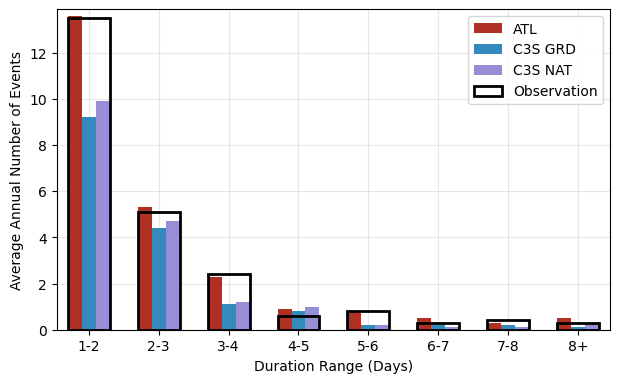

In [9]:
fig, ax = plt.subplots(1, 1, 
                       figsize = (16*cm, 10*cm),
                       sharey = True)

for i, name in enumerate(categories['wind']):
    df = droughts_dict[name]
    df['DurationRange'] = pd.cut(df['Duration'], bins = duration_ranges_hours)
    df['Year'] = df.index.year
    annual_counts = df.groupby(['Year', 'DurationRange'], observed = True).size().unstack(fill_value = 0)

    mean_counts = annual_counts.mean()
    std_counts = annual_counts.std()
    duration_midpoints = [((dur.left + dur.right) / 2) / 24 for dur in mean_counts.index]

    if i == 0:
        eirgrid_heights = mean_counts.values
    else:
        ax.bar(positions + (i - 1) * bar_width - 0.2, mean_counts,
               width = bar_width,
               color = color_models[i],
               label = label_name[i],
               zorder = 2)

if eirgrid_heights is not None:
    ax.bar(positions, eirgrid_heights,  
           width = bar_width * 3,        
           facecolor = 'none',
           edgecolor = 'black',
           linewidth = 2,
           label = 'Observation',
           zorder = 3)

# X-axis
ax.set_xlabel('Duration Range (Days)')
ax.set_xticks(np.arange(len(duration_ranges_days)))
ax.set_xticklabels(xlabel)

# Y-axis
ax.set_ylabel('Average Annual Number of Events')

# Grid
ax.margins(0.02)
ax.grid(True, alpha = 0.3, zorder = 0)

# Legend
ax.legend(loc = 'upper right')
fig.tight_layout()
# fig.savefig('5_verification_wind_number_events.pdf', bbox_inches = 'tight')